In [196]:
%matplotlib inline
from __future__ import division
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pickle
from operator import itemgetter
from mpl_toolkits.mplot3d import Axes3D
import sklearn
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import matplotlib.animation as animation

In [197]:
# 0 eid
# 1 rid
# 2 qtot
# 3 qdom
# 4 prim_en
# 5 prim_time
# 6 prim_table_time
# 7 prim_table_charge
# 8 prim_pos
# 9 prim_dir
# 10 tau_en
# 11 tau_time
# 12 tau_table_time
# 13 tau_table_charge
# 14 tau_len
# 15 tau_pos
# 16 tau_dir
# 17 om.string
# 18 om.om
# 19 om_pos
# 20 start_time
# 21 wf_vect
# 22 wf_binwidth
c =0.299792458
n =1.3195
v=c/n 
print v

0.227201559682


In [198]:
t1 = pickle.load(open("DoublePulseWaveformTau1PeV.pkl", "rb"))
print len(t1), len(t1[57]),len(t1[57][0]),len(t1[57][0][21])

156 984 23 128


In [199]:
t1 = [i for i in t1 if len(i)>0]
print len(t1), len(t1[57]),len(t1[57][0]),len(t1[57][0][21])
for i in t1:
    print "{0}, {1}, {2}, En{3:2.2e}GeV, Et{4:2.2e}GeV, Q{5:.1f}PE".format(t1.index(i),i[0][0],i[0][1],i[0][4],i[0][10], i[0][2])

153 984 23 128
0, 631, 76, En1.43e+06GeV, Et1.06e+06GeV, Q120.1PE
1, 261, 86, En1.32e+06GeV, Et1.16e+06GeV, Q23433.8PE
2, 409, 72, En1.07e+06GeV, Et1.03e+06GeV, Q74635.2PE
3, 436, 72, En1.17e+06GeV, Et1.07e+06GeV, Q82397.2PE
4, 737, 72, En1.05e+06GeV, Et1.02e+06GeV, Q33997.9PE
5, 99, 30, En1.53e+06GeV, Et1.00e+06GeV, Q1325.3PE
6, 189, 30, En1.00e+06GeV, Et1.00e+06GeV, Q98646.3PE
7, 277, 30, En1.55e+06GeV, Et1.16e+06GeV, Q3747.8PE
8, 533, 30, En1.35e+06GeV, Et1.10e+06GeV, Q1894.1PE
9, 133, 19, En1.07e+06GeV, Et1.07e+06GeV, Q65422.3PE
10, 314, 19, En2.21e+06GeV, Et1.08e+06GeV, Q10390.8PE
11, 340, 28, En1.15e+06GeV, Et1.11e+06GeV, Q635.1PE
12, 630, 28, En1.02e+06GeV, Et1.01e+06GeV, Q645.8PE
13, 634, 28, En1.52e+06GeV, Et1.19e+06GeV, Q3869.2PE
14, 569, 98, En2.57e+06GeV, Et1.05e+06GeV, Q1602.1PE
15, 755, 98, En1.17e+06GeV, Et1.15e+06GeV, Q64554.0PE
16, 171, 54, En2.69e+06GeV, Et1.12e+06GeV, Q3667.2PE
17, 224, 54, En1.39e+06GeV, Et1.06e+06GeV, Q13994.4PE
18, 263, 54, En1.36e+06GeV, Et1.10e+

In [200]:
def b2_pos_calc(one, one_dir, length):
    if length > 0:
        l_x = np.sin(one_dir[0])*np.cos(one_dir[1])*length
        l_y = np.sin(one_dir[0])*np.sin(one_dir[1])*length
        l_z = np.cos(one_dir[0])*length
    two = [0,0,0]
    two[0] = one[0]-l_x 
    two[1] = one[1]-l_y 
    two[2] = one[2]-l_z 
    
    return two

In [201]:
def make_data(data):
    events = []
    events_true = []
    
    for i in data:
        b1_pos = i[0][8]
        b1_time = i[0][5]
        b2_pos = b2_pos_calc(i[0][8],i[0][9],i[0][14])
        b2_time = i[0][11]
        
        samples = []
        weight = []
        dom = []
        for j in i:
            wf = j[21]
            start = j[20]
            pos = j[19]
            wf_w = j[22]
            for k in wf:
                dom.append([j[0],j[1],j[2],j[3],j[4],j[17],j[18]])
                t = (start+wf.index(k)*wf_w)*v
                x = pos[0]
                y = pos[1]
                z = pos[2]
                samples.append([x,y,z,t])
                if k>0:
                    weight.append(k/10**(-12))
                else:
                    weight.append(0)
        events.append([samples, weight, dom])
        events_true.append([[b1_pos[0],b1_pos[1],b1_pos[2], b1_time*v], [b2_pos[0],b2_pos[1],b2_pos[2], b2_time*v]])
    return events, events_true

In [202]:
data, truth, doms = make_data(t1)

In [203]:
print len(data), len(data[57]),len(data[57][0]),len(data[57][1]),len(data[57][2]),len(data[57][2][0])
print len(truth), len(truth[0]), data[0][1][:10], sum(data[0][1])


153 3 125952 125952 125952 7
153 2 [0, 0, 0, 0, 0, 0, 1.3705354748000653, 3.7014689335723796, 4.38514979072558, 3.170293499331177] 930.384237354


In [204]:
def make_plots(y_pred, data, weight, truth):
    
    split = zip(y_pred, data, weight)
    one = [[i[1],i[2]] for i in split if i[0]==1]
    two = [[i[1],i[2]] for i in split if i[0]==0]
    tri = truth
    print len(split), len(one), len(two)
    one_x = [i[0][0] for i in one]
    one_y = [i[0][1] for i in one]
    one_z = [i[0][2] for i in one]
    one_t = [i[0][3] for i in one]
    one_s = [i[1] for i in one]
     
    two_x = [i[0][0] for i in two]
    two_y = [i[0][1] for i in two]
    two_z = [i[0][2] for i in two]
    two_t = [i[0][3] for i in two]
    two_s = [i[1] for i in two]
    
    tri_x = [i[0] for i in tri]
    tri_y = [i[1] for i in tri]
    tri_z = [i[2] for i in tri]
    tri_t = [i[3] for i in tri]
    tri_s = [1000 for i in tri]
    
    fig1 = plt.figure(figsize=(12, 12))
    ax = fig1.add_subplot(111, projection='3d')
    ax.scatter(one_x, one_y, one_z, s=one_s, c='r', marker='.')
    ax.scatter(two_x, two_y, two_z, s=two_s, c='b', marker='.')
    ax.scatter(tri_x, tri_y, tri_z, s=tri_s, c='g', marker='.')
    ax.view_init(0, 30)
    
    fig2 = plt.figure(figsize=(6, 6))
    ax = fig2.add_subplot(311)
    ax.set_xlabel("Time, ns", fontsize = 14)                                                              
    ax.set_ylabel("X, m", fontsize = 14)
    ax.scatter(one_t, one_x,  s=one_s, c='r', marker='.')
    ax.scatter(two_t, two_x, s=two_s, c='b', marker='.')
    ax.scatter(tri_t, tri_x, s=tri_s, c='g', marker='.')
    ax = fig2.add_subplot(312)
    ax.set_xlabel("Time, ns", fontsize = 14)                                                              
    ax.set_ylabel("Y, m", fontsize = 14)
    ax.scatter(one_t, one_y, s=one_s, c='r', marker='.')
    ax.scatter(two_t, two_y, s=two_s, c='b', marker='.')
    ax.scatter(tri_t, tri_y, s=tri_s, c='g', marker='.')
    ax = fig2.add_subplot(313)
    ax.set_xlabel("Time, ns", fontsize = 14)                                                              
    ax.set_ylabel("Z, m", fontsize = 14)
    ax.scatter(one_t, one_z, s=two_s, c='r', marker='.')
    ax.scatter(two_t, two_z, s=two_s, c='b', marker='.')
    ax.scatter(tri_t, tri_z, s=tri_s, c='g', marker='.')
    plt.show()

In [205]:
def make_movie_points(y_pred, data, weight, truth):
    l = [list(i) for i in zip(data, y_pred, weight)]
    l2 = []
    for i in l:
        l2.append([i[0][0],i[0][1],i[0][2],i[0][3],i[1],i[2]])
    for i in truth:
        l2.append([i[0],i[1],i[2],i[3],99,1000])
    sor = sorted(l2, key=itemgetter(3))

    bins = []
    count = 0
    temp = []
    for i in sor:
        temp.append(i)
        if len(temp)==100:
            bins.append(temp)
            temp = []
    
    print len(bins)
    
    x1,y1,z1,s1 = [],[],[],[] 
    x2,y2,z2,s2 = [],[],[],[] 
    x3,y3,z3,s3 = [],[],[],[] 
           
    count = 0
    for i in bins:
        count = count +1
        fig = plt.figure(figsize=(12, 12))
        ax = fig.add_subplot(111, projection='3d')
        ax.view_init(0, 30)
        ax.set_xlim(-500,500)
        ax.set_ylim(-500,500)
        ax.set_zlim(-500,500)
        if len(i) >0:
            for j in i:
                if j[4] ==1:
                    x1.append(j[0])
                    y1.append(j[1])
                    z1.append(j[2])
                    s1.append(j[5])
                elif j[4] ==0:
                    x2.append(j[0])
                    y2.append(j[1])
                    z2.append(j[2])
                    s2.append(j[5])
                elif j[4] ==99:
                    x3.append(j[0])
                    y3.append(j[1])
                    z3.append(j[2])
                    s3.append(j[5])

                   
        name = '/home/dup193/work/notebook/movie/pic_points_{0:04d}.png'.format(count)
        ax.scatter(x1,y1,z1,s=s1,c='r', alpha =0.5, marker='o')
        ax.scatter(x2,y2,z2,s=s2,c='b', alpha =0.5, marker='o')
        ax.scatter(x3,y3,z3,s=s3,c='g', alpha =0.5, marker='o')
        plt.savefig(name)
        print name, len(i)
        plt.close(fig)

In [206]:
def make_movie_times(y_pred, data, weight, truth):
    l = [list(i) for i in zip(data, y_pred, weight)]
    l2 = []
    for i in l:
        l2.append([i[0][0],i[0][1],i[0][2],i[0][3],i[1],i[2]])
    for i in truth:
        l2.append([i[0],i[1],i[2],i[3],99,1000])
    
    sor = sorted(l2, key=itemgetter(3))

    mint = sor[0][3]
    maxt = sor[-1][3]
    
    bins = []
    ts = range(int(mint), int(maxt), 10)

    for i in range(0, len(ts)-1):
        bins.append([j for j in sor if ts[i]<j[3]<ts[i+1]])
    
    print len(bins)
    
    x1,y1,z1,s1 = [],[],[],[] 
    x2,y2,z2,s2 = [],[],[],[] 
    x3,y3,z3,s3 = [],[],[],[] 
    x4,y4,z4,s4 = [],[],[],[]        
    count = 0
    for i in bins:
        count = count +1
        fig = plt.figure(figsize=(12, 12))
        ax = fig.add_subplot(111, projection='3d')
        ax.view_init(0, 30)
        ax.set_xlim(-500,500)
        ax.set_ylim(-500,500)
        ax.set_zlim(-500,500)
        if len(i) >0:
            for j in i:
                if j[4] ==1:
                    x1.append(j[0])
                    y1.append(j[1])
                    z1.append(j[2])
                    s1.append(j[5])
                elif j[4] ==0:
                    x2.append(j[0])
                    y2.append(j[1])
                    z2.append(j[2])
                    s2.append(j[5])
                elif j[4] ==99:
                    x3.append(j[0])
                    y3.append(j[1])
                    z3.append(j[2])
                    s3.append(j[5])
                else:
                    x4.append(j[0])
                    y4.append(j[1])
                    z4.append(j[2])
                    s4.append(j[5])

                   
        name = '/home/dup193/work/notebook/movie/pic_times_{0:04d}.png'.format(count)
        ax.scatter(x1,y1,z1,s=s1,c='r', alpha =0.5, marker='o')
        ax.scatter(x2,y2,z2,s=s2,c='b', alpha =0.5, marker='o')
        ax.scatter(x3,y3,z3,s=s3,c='g', alpha =0.5, marker='o')
        ax.scatter(x4,y4,z4,s=s4,c='k', alpha =0.5, marker='o')
        plt.savefig(name)
        print name, len(i)
        plt.close(fig)

In [207]:
def make_movie_times_slide(y_pred, data, weight, truth):
    l = [list(i) for i in zip(data, y_pred, weight)]
    l2 = []
    for i in l:
        l2.append([i[0][0],i[0][1],i[0][2],i[0][3],i[1],i[2]])
    for i in truth:
        l2.append([i[0],i[1],i[2],i[3],99,1000])
    
    sor = sorted(l2, key=itemgetter(3))

    mint = sor[0][3]
    maxt = sor[-1][3]
    
    bins = []
    ts = range(int(mint), int(maxt), 10)

    for i in range(0, len(ts)-1):
        bins.append([j for j in sor if ts[i]<j[3]<ts[i+1]])
    
    print len(bins)
    
    x3,y3,z3,s3 = [],[],[],[]        
    count = 0
    for i in bins:
        x1,y1,z1,s1 = [],[],[],[] 
        x2,y2,z2,s2 = [],[],[],[] 
        x4,y4,z4,s4 = [],[],[],[] 
        count = count +1
        fig = plt.figure(figsize=(12, 12))
        ax = fig.add_subplot(111, projection='3d')
        ax.view_init(0, 30)
        ax.set_xlim(-500,500)
        ax.set_ylim(-500,500)
        ax.set_zlim(-500,500)
        ax.view_init(0, 30)
        if len(i) >0:
            for j in i:
                if j[4] ==1:
                    x1.append(j[0])
                    y1.append(j[1])
                    z1.append(j[2])
                    s1.append(j[5])
                elif j[4] ==0:
                    x2.append(j[0])
                    y2.append(j[1])
                    z2.append(j[2])
                    s2.append(j[5])
                elif j[4] ==99:
                    x3.append(j[0])
                    y3.append(j[1])
                    z3.append(j[2])
                    s3.append(j[5])
                else:
                    x4.append(j[0])
                    y4.append(j[1])
                    z4.append(j[2])
                    s4.append(j[5])

                   
        name = '/home/dup193/work/notebook/movie/pic_times_{0:04d}.png'.format(count)
        ax.scatter(x1,y1,z1,s=s1,c='r', alpha =0.5, marker='o', label = 'bang1')
        ax.scatter(x2,y2,z2,s=s2,c='b', alpha =0.5, marker='o', label = 'bang2')
        ax.scatter(x3,y3,z3,s=s3,c='g', alpha =0.5, marker='o', label = 'TrueVertex')
        ax.scatter(x4,y4,z4,s=s4,c='k', alpha =0.5, marker='o', label = 'other')
        plt.savefig(name)
        plt.legend()
        print name, len(i)
        plt.close(fig)

125952 47049 78903


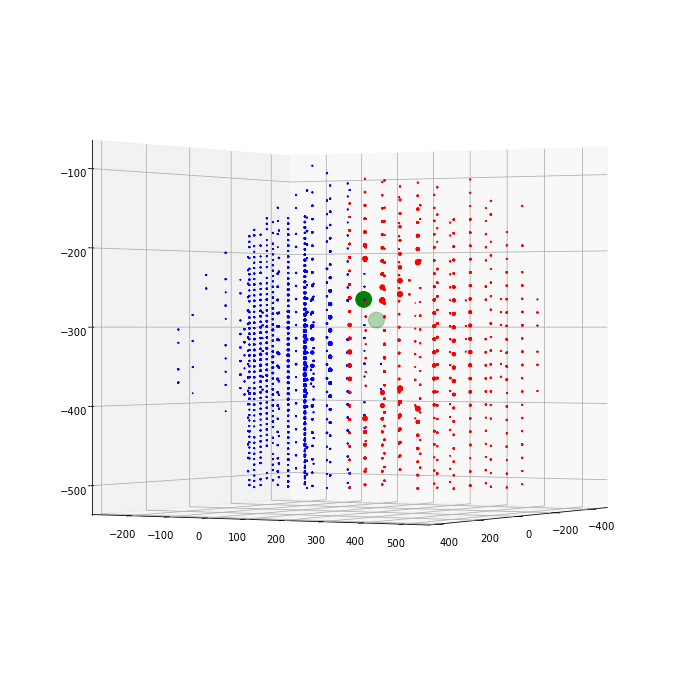

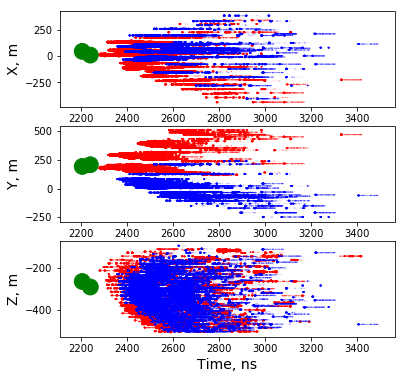

In [13]:
y_pred_57 = KMeans(n_clusters=2).fit_predict(data[57][0],data[57][1])
make_plots(y_pred_57,data[57][0],data[57][1],truth[57])

In [42]:
make_movie_times(y_pred_1,data[1][0],data[1][1],truth[1])

203
/home/dup193/work/notebook/movie/pic_times_0001.png 1
/home/dup193/work/notebook/movie/pic_times_0002.png 0
/home/dup193/work/notebook/movie/pic_times_0003.png 0
/home/dup193/work/notebook/movie/pic_times_0004.png 0
/home/dup193/work/notebook/movie/pic_times_0005.png 0
/home/dup193/work/notebook/movie/pic_times_0006.png 0
/home/dup193/work/notebook/movie/pic_times_0007.png 0
/home/dup193/work/notebook/movie/pic_times_0008.png 0
/home/dup193/work/notebook/movie/pic_times_0009.png 0
/home/dup193/work/notebook/movie/pic_times_0010.png 0
/home/dup193/work/notebook/movie/pic_times_0011.png 3
/home/dup193/work/notebook/movie/pic_times_0012.png 13
/home/dup193/work/notebook/movie/pic_times_0013.png 25
/home/dup193/work/notebook/movie/pic_times_0014.png 27
/home/dup193/work/notebook/movie/pic_times_0015.png 26
/home/dup193/work/notebook/movie/pic_times_0016.png 35
/home/dup193/work/notebook/movie/pic_times_0017.png 39
/home/dup193/work/notebook/movie/pic_times_0018.png 53
/home/dup193/work

/home/dup193/work/notebook/movie/pic_times_0148.png 480
/home/dup193/work/notebook/movie/pic_times_0149.png 504
/home/dup193/work/notebook/movie/pic_times_0150.png 448
/home/dup193/work/notebook/movie/pic_times_0151.png 457
/home/dup193/work/notebook/movie/pic_times_0152.png 469
/home/dup193/work/notebook/movie/pic_times_0153.png 503
/home/dup193/work/notebook/movie/pic_times_0154.png 476
/home/dup193/work/notebook/movie/pic_times_0155.png 488
/home/dup193/work/notebook/movie/pic_times_0156.png 477
/home/dup193/work/notebook/movie/pic_times_0157.png 505
/home/dup193/work/notebook/movie/pic_times_0158.png 474
/home/dup193/work/notebook/movie/pic_times_0159.png 388
/home/dup193/work/notebook/movie/pic_times_0160.png 380
/home/dup193/work/notebook/movie/pic_times_0161.png 328
/home/dup193/work/notebook/movie/pic_times_0162.png 310
/home/dup193/work/notebook/movie/pic_times_0163.png 319
/home/dup193/work/notebook/movie/pic_times_0164.png 325
/home/dup193/work/notebook/movie/pic_times_0165.

In [43]:
make_movie_times_slide(y_pred_1,data[1][0],data[1][1],truth[1])

203
/home/dup193/work/notebook/movie/pic_times_0001.png 1
/home/dup193/work/notebook/movie/pic_times_0002.png 0
/home/dup193/work/notebook/movie/pic_times_0003.png 0
/home/dup193/work/notebook/movie/pic_times_0004.png 0
/home/dup193/work/notebook/movie/pic_times_0005.png 0
/home/dup193/work/notebook/movie/pic_times_0006.png 0
/home/dup193/work/notebook/movie/pic_times_0007.png 0
/home/dup193/work/notebook/movie/pic_times_0008.png 0
/home/dup193/work/notebook/movie/pic_times_0009.png 0
/home/dup193/work/notebook/movie/pic_times_0010.png 0
/home/dup193/work/notebook/movie/pic_times_0011.png 3
/home/dup193/work/notebook/movie/pic_times_0012.png 13
/home/dup193/work/notebook/movie/pic_times_0013.png 25
/home/dup193/work/notebook/movie/pic_times_0014.png 27
/home/dup193/work/notebook/movie/pic_times_0015.png 26
/home/dup193/work/notebook/movie/pic_times_0016.png 35
/home/dup193/work/notebook/movie/pic_times_0017.png 39
/home/dup193/work/notebook/movie/pic_times_0018.png 53
/home/dup193/work

/home/dup193/work/notebook/movie/pic_times_0148.png 480
/home/dup193/work/notebook/movie/pic_times_0149.png 504
/home/dup193/work/notebook/movie/pic_times_0150.png 448
/home/dup193/work/notebook/movie/pic_times_0151.png 457
/home/dup193/work/notebook/movie/pic_times_0152.png 469
/home/dup193/work/notebook/movie/pic_times_0153.png 503
/home/dup193/work/notebook/movie/pic_times_0154.png 476
/home/dup193/work/notebook/movie/pic_times_0155.png 488
/home/dup193/work/notebook/movie/pic_times_0156.png 477
/home/dup193/work/notebook/movie/pic_times_0157.png 505
/home/dup193/work/notebook/movie/pic_times_0158.png 474
/home/dup193/work/notebook/movie/pic_times_0159.png 388
/home/dup193/work/notebook/movie/pic_times_0160.png 380
/home/dup193/work/notebook/movie/pic_times_0161.png 328
/home/dup193/work/notebook/movie/pic_times_0162.png 310
/home/dup193/work/notebook/movie/pic_times_0163.png 319
/home/dup193/work/notebook/movie/pic_times_0164.png 325
/home/dup193/work/notebook/movie/pic_times_0165.

125952 38232 87720


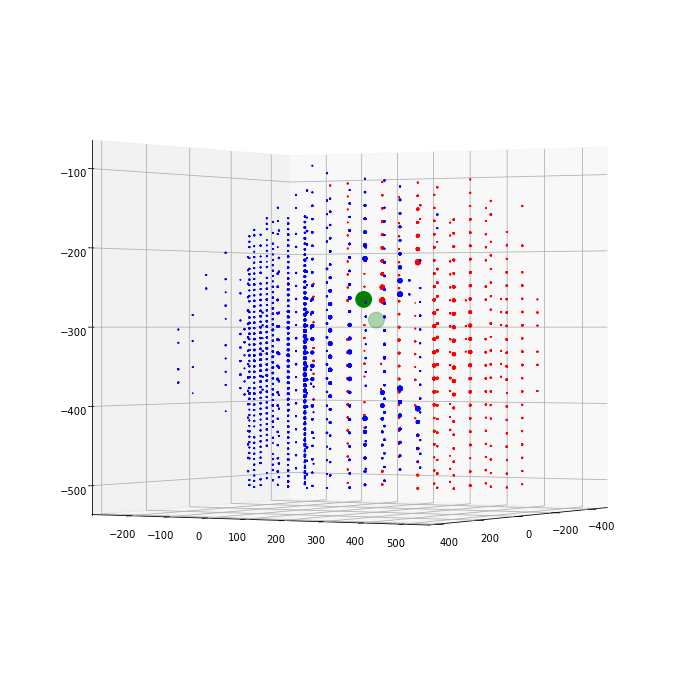

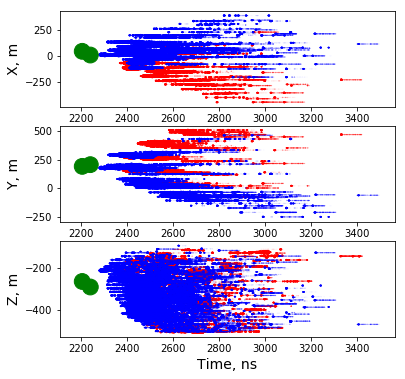

In [208]:
y_pred_57_birch = Birch(n_clusters=2,branching_factor=5, threshold=50 ).fit_predict(data[57][0],data[57][1])
make_plots(y_pred_57_birch,data[57][0],data[57][1],truth[57])


In [43]:
make_movie_times(y_pred_57_birch,data[57][0],data[57][1],truth[57])

128
/home/dup193/work/notebook/movie/pic_times_0001.png 1
/home/dup193/work/notebook/movie/pic_times_0002.png 0
/home/dup193/work/notebook/movie/pic_times_0003.png 0
/home/dup193/work/notebook/movie/pic_times_0004.png 1
/home/dup193/work/notebook/movie/pic_times_0005.png 0
/home/dup193/work/notebook/movie/pic_times_0006.png 0
/home/dup193/work/notebook/movie/pic_times_0007.png 2
/home/dup193/work/notebook/movie/pic_times_0008.png 13
/home/dup193/work/notebook/movie/pic_times_0009.png 14
/home/dup193/work/notebook/movie/pic_times_0010.png 26
/home/dup193/work/notebook/movie/pic_times_0011.png 54
/home/dup193/work/notebook/movie/pic_times_0012.png 119
/home/dup193/work/notebook/movie/pic_times_0013.png 167
/home/dup193/work/notebook/movie/pic_times_0014.png 187
/home/dup193/work/notebook/movie/pic_times_0015.png 231
/home/dup193/work/notebook/movie/pic_times_0016.png 286
/home/dup193/work/notebook/movie/pic_times_0017.png 387
/home/dup193/work/notebook/movie/pic_times_0018.png 478
/home/

In [18]:
make_movie_times_slide(y_pred_57_birch,data[57][0],data[57][1],truth[57])

128
/home/dup193/work/notebook/movie/pic_times_0001.png 1
/home/dup193/work/notebook/movie/pic_times_0002.png 0
/home/dup193/work/notebook/movie/pic_times_0003.png 0
/home/dup193/work/notebook/movie/pic_times_0004.png 1
/home/dup193/work/notebook/movie/pic_times_0005.png 0
/home/dup193/work/notebook/movie/pic_times_0006.png 0
/home/dup193/work/notebook/movie/pic_times_0007.png 2
/home/dup193/work/notebook/movie/pic_times_0008.png 13
/home/dup193/work/notebook/movie/pic_times_0009.png 14
/home/dup193/work/notebook/movie/pic_times_0010.png 26
/home/dup193/work/notebook/movie/pic_times_0011.png 54
/home/dup193/work/notebook/movie/pic_times_0012.png 119
/home/dup193/work/notebook/movie/pic_times_0013.png 167
/home/dup193/work/notebook/movie/pic_times_0014.png 187
/home/dup193/work/notebook/movie/pic_times_0015.png 231
/home/dup193/work/notebook/movie/pic_times_0016.png 286
/home/dup193/work/notebook/movie/pic_times_0017.png 387
/home/dup193/work/notebook/movie/pic_times_0018.png 478
/home/

In [14]:
gmm = GaussianMixture(n_components=2).fit(data[57][0],data[57][1])

In [15]:
y_pred_57_Mix = gmm.predict(data[57][0])

125952 66302 59650


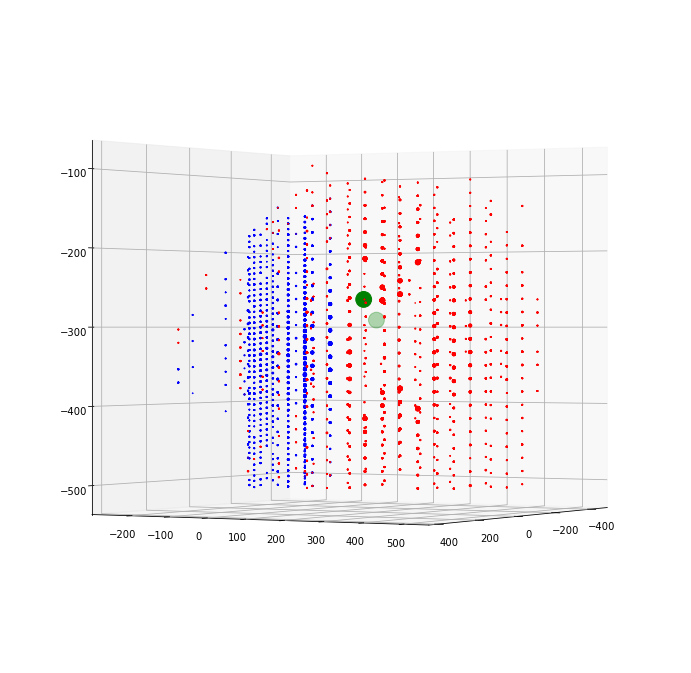

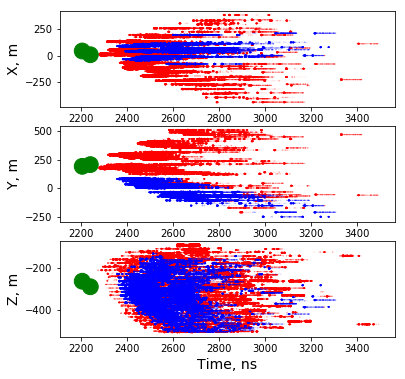

In [16]:
make_plots(y_pred_57_Mix,data[57][0],data[57][1],truth[57])

In [ ]:
y_pred_57_DBS = DBSCAN(eps=6000, min_samples=1000).fit_predict(data[57][0],data[57][1])
make_plots(y_pred_57_DBS,data[57][0],data[57][1],truth[57])

In [16]:
print y_pred_2_DBS[90000:90010]

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


In [ ]:
y_pred_125= KMeans(n_clusters=2).fit_predict(data[125][0],data[125][1])
make_plots(y_pred_125,data[125][0],data[125][1],truth[125])

104192 71495 32697


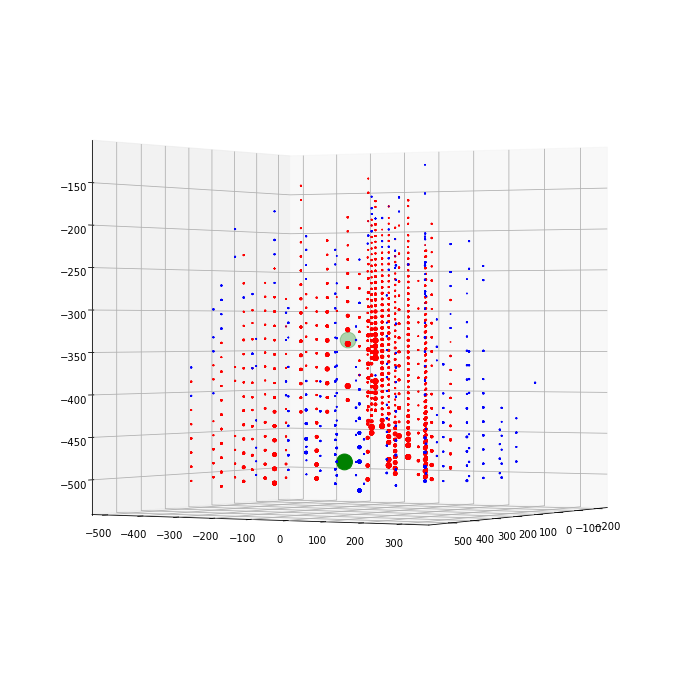

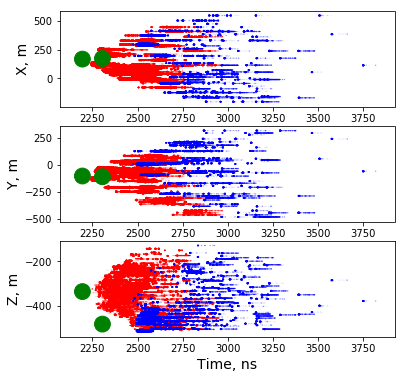

In [209]:
y_pred_125_birch= Birch(n_clusters=2,branching_factor=5, threshold=50 ).fit_predict(data[125][0],data[125][1])
make_plots(y_pred_125_birch,data[125][0],data[125][1],truth[125])

In [15]:
make_movie_times(y_pred_125_birch,data[125][0],data[125][1],truth[125])

164
/home/dup193/work/notebook/movie/pic_times_0001.png 1
/home/dup193/work/notebook/movie/pic_times_0002.png 0
/home/dup193/work/notebook/movie/pic_times_0003.png 0
/home/dup193/work/notebook/movie/pic_times_0004.png 0
/home/dup193/work/notebook/movie/pic_times_0005.png 16
/home/dup193/work/notebook/movie/pic_times_0006.png 34
/home/dup193/work/notebook/movie/pic_times_0007.png 54
/home/dup193/work/notebook/movie/pic_times_0008.png 173
/home/dup193/work/notebook/movie/pic_times_0009.png 314
/home/dup193/work/notebook/movie/pic_times_0010.png 476
/home/dup193/work/notebook/movie/pic_times_0011.png 574
/home/dup193/work/notebook/movie/pic_times_0012.png 775
/home/dup193/work/notebook/movie/pic_times_0013.png 1019
/home/dup193/work/notebook/movie/pic_times_0014.png 1208
/home/dup193/work/notebook/movie/pic_times_0015.png 1343
/home/dup193/work/notebook/movie/pic_times_0016.png 1517
/home/dup193/work/notebook/movie/pic_times_0017.png 1737
/home/dup193/work/notebook/movie/pic_times_0018.pn

/home/dup193/work/notebook/movie/pic_times_0148.png 7
/home/dup193/work/notebook/movie/pic_times_0149.png 0
/home/dup193/work/notebook/movie/pic_times_0150.png 0
/home/dup193/work/notebook/movie/pic_times_0151.png 0
/home/dup193/work/notebook/movie/pic_times_0152.png 0
/home/dup193/work/notebook/movie/pic_times_0153.png 0
/home/dup193/work/notebook/movie/pic_times_0154.png 0
/home/dup193/work/notebook/movie/pic_times_0155.png 0
/home/dup193/work/notebook/movie/pic_times_0156.png 11
/home/dup193/work/notebook/movie/pic_times_0157.png 13
/home/dup193/work/notebook/movie/pic_times_0158.png 13
/home/dup193/work/notebook/movie/pic_times_0159.png 13
/home/dup193/work/notebook/movie/pic_times_0160.png 13
/home/dup193/work/notebook/movie/pic_times_0161.png 14
/home/dup193/work/notebook/movie/pic_times_0162.png 13
/home/dup193/work/notebook/movie/pic_times_0163.png 13
/home/dup193/work/notebook/movie/pic_times_0164.png 13


In [17]:
make_movie_times_slide(y_pred_125_birch,data[125][0],data[125][1],truth[125])

164
/home/dup193/work/notebook/movie/pic_times_0001.png 1
/home/dup193/work/notebook/movie/pic_times_0002.png 0
/home/dup193/work/notebook/movie/pic_times_0003.png 0
/home/dup193/work/notebook/movie/pic_times_0004.png 0
/home/dup193/work/notebook/movie/pic_times_0005.png 16
/home/dup193/work/notebook/movie/pic_times_0006.png 34
/home/dup193/work/notebook/movie/pic_times_0007.png 54
/home/dup193/work/notebook/movie/pic_times_0008.png 173
/home/dup193/work/notebook/movie/pic_times_0009.png 314
/home/dup193/work/notebook/movie/pic_times_0010.png 476
/home/dup193/work/notebook/movie/pic_times_0011.png 574
/home/dup193/work/notebook/movie/pic_times_0012.png 775
/home/dup193/work/notebook/movie/pic_times_0013.png 1019
/home/dup193/work/notebook/movie/pic_times_0014.png 1208
/home/dup193/work/notebook/movie/pic_times_0015.png 1343
/home/dup193/work/notebook/movie/pic_times_0016.png 1517
/home/dup193/work/notebook/movie/pic_times_0017.png 1737
/home/dup193/work/notebook/movie/pic_times_0018.pn

/home/dup193/work/notebook/movie/pic_times_0148.png 7
/home/dup193/work/notebook/movie/pic_times_0149.png 0
/home/dup193/work/notebook/movie/pic_times_0150.png 0
/home/dup193/work/notebook/movie/pic_times_0151.png 0
/home/dup193/work/notebook/movie/pic_times_0152.png 0
/home/dup193/work/notebook/movie/pic_times_0153.png 0
/home/dup193/work/notebook/movie/pic_times_0154.png 0
/home/dup193/work/notebook/movie/pic_times_0155.png 0
/home/dup193/work/notebook/movie/pic_times_0156.png 11
/home/dup193/work/notebook/movie/pic_times_0157.png 13
/home/dup193/work/notebook/movie/pic_times_0158.png 13
/home/dup193/work/notebook/movie/pic_times_0159.png 13
/home/dup193/work/notebook/movie/pic_times_0160.png 13
/home/dup193/work/notebook/movie/pic_times_0161.png 14
/home/dup193/work/notebook/movie/pic_times_0162.png 13
/home/dup193/work/notebook/movie/pic_times_0163.png 13
/home/dup193/work/notebook/movie/pic_times_0164.png 13


In [23]:
gmm = GaussianMixture(n_components=2).fit(data[125][0],data[125][1])

In [24]:
y_pred_125_Mix = gmm.predict(data[125][0])

104192 57167 47025


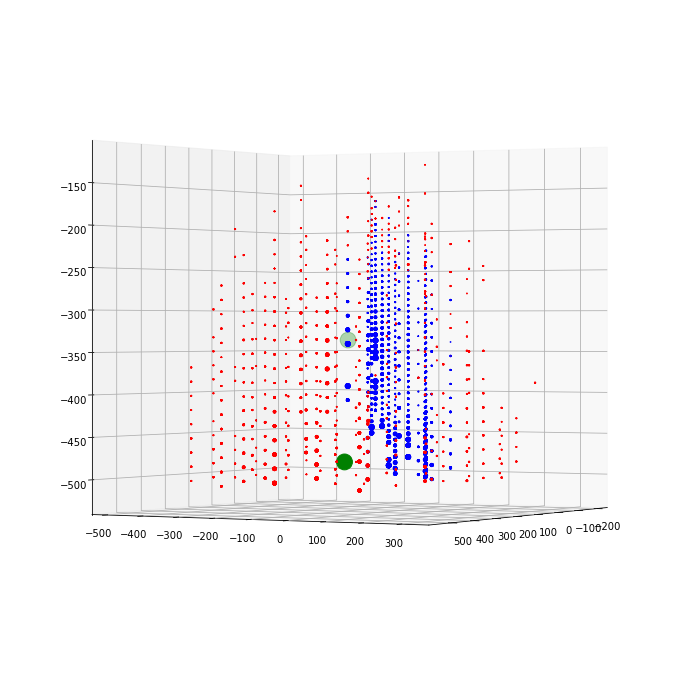

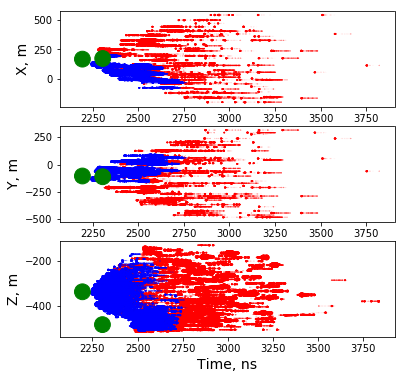

In [25]:
make_plots(y_pred_125_Mix,data[125][0],data[125][1],truth[125])

104192 23649 80543


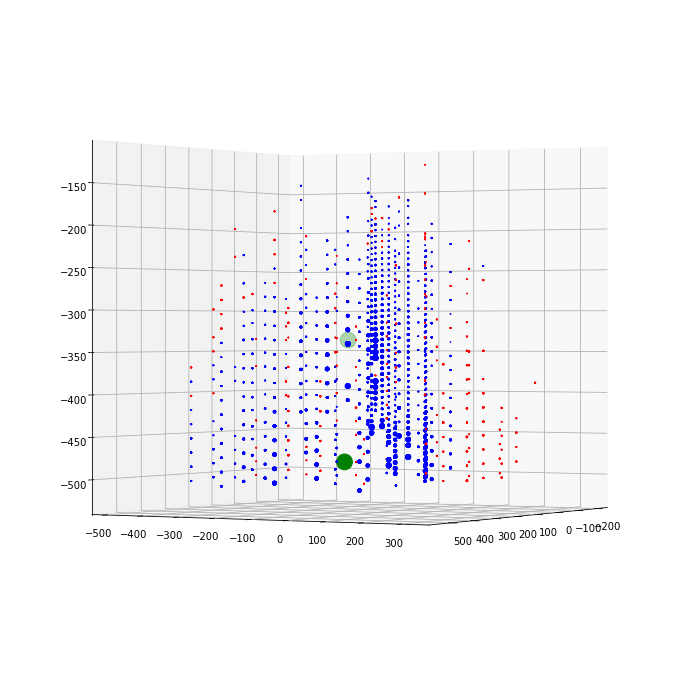

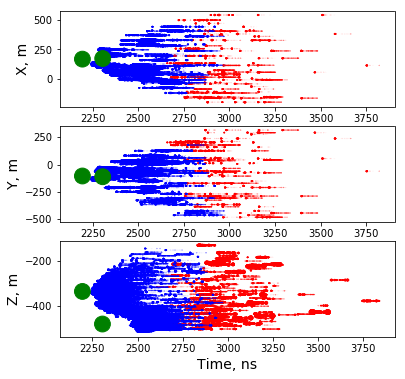

In [27]:
y_pred_125_AC=  AgglomerativeClustering(n_clusters=2).fit_predict(data[125][0],data[125][1])
make_plots(y_pred_125_AC,data[125][0],data[125][1],truth[125])

In [28]:
make_movie_times_slide(y_pred_125_AC,data[125][0],data[125][1],truth[125])

164
/home/dup193/work/notebook/movie/pic_times_0001.png 1
/home/dup193/work/notebook/movie/pic_times_0002.png 0
/home/dup193/work/notebook/movie/pic_times_0003.png 0
/home/dup193/work/notebook/movie/pic_times_0004.png 0
/home/dup193/work/notebook/movie/pic_times_0005.png 16
/home/dup193/work/notebook/movie/pic_times_0006.png 34
/home/dup193/work/notebook/movie/pic_times_0007.png 54
/home/dup193/work/notebook/movie/pic_times_0008.png 173
/home/dup193/work/notebook/movie/pic_times_0009.png 314
/home/dup193/work/notebook/movie/pic_times_0010.png 476
/home/dup193/work/notebook/movie/pic_times_0011.png 574
/home/dup193/work/notebook/movie/pic_times_0012.png 775
/home/dup193/work/notebook/movie/pic_times_0013.png 1019
/home/dup193/work/notebook/movie/pic_times_0014.png 1208
/home/dup193/work/notebook/movie/pic_times_0015.png 1343
/home/dup193/work/notebook/movie/pic_times_0016.png 1517
/home/dup193/work/notebook/movie/pic_times_0017.png 1737
/home/dup193/work/notebook/movie/pic_times_0018.pn

/home/dup193/work/notebook/movie/pic_times_0148.png 7
/home/dup193/work/notebook/movie/pic_times_0149.png 0
/home/dup193/work/notebook/movie/pic_times_0150.png 0
/home/dup193/work/notebook/movie/pic_times_0151.png 0
/home/dup193/work/notebook/movie/pic_times_0152.png 0
/home/dup193/work/notebook/movie/pic_times_0153.png 0
/home/dup193/work/notebook/movie/pic_times_0154.png 0
/home/dup193/work/notebook/movie/pic_times_0155.png 0
/home/dup193/work/notebook/movie/pic_times_0156.png 11
/home/dup193/work/notebook/movie/pic_times_0157.png 13
/home/dup193/work/notebook/movie/pic_times_0158.png 13
/home/dup193/work/notebook/movie/pic_times_0159.png 13
/home/dup193/work/notebook/movie/pic_times_0160.png 13
/home/dup193/work/notebook/movie/pic_times_0161.png 14
/home/dup193/work/notebook/movie/pic_times_0162.png 13
/home/dup193/work/notebook/movie/pic_times_0163.png 13
/home/dup193/work/notebook/movie/pic_times_0164.png 13


In [20]:
AA = sklearn.metrics.pairwise.euclidean_distances(data[125][0], data[125][0])

In [ ]:
y_pred_125_DBS = DBSCAN(eps=1000, min_samples=200, metric = 'precomputed').fit_predict(AA)
make_plots(y_pred_125_DBS,data[125][0],data[125][1],truth[125])

In [ ]:
y_pred_125_DBS = DBSCAN(eps=1000, min_samples=200).fit_predict(data[125][0],data[125][1])
make_plots(y_pred_125_DBS,data[125][0],data[125][1],truth[125])

In [210]:
print data[125][0][0],data[125][1][0],data[125][2][0]


[-9.130000114440918, -481.739990234375, -334.7799987792969, 3055.184833976941] 0 [222, 23, 52051.35003066808, 0.7250000238418579, 1195523.7311754613, 3, 50]


In [264]:
dtype = [('eid',int),('rid',int),('qtot',float),('qdom',float),('energy',float),('string',int),('om',int),('t',float),('q',float),('label',int)]
def PlotWave(labels,data,name):
    print len(labels), len(data[0]),len(data[1]),len(data[2])
    xs = np.array([i for i in range(128)])
    data_zip = [tuple(i[3]+[i[1][3]/v]+[i[2]]+[i[0]]) for i in zip(labels,data[0],data[1],data[2])]
    D = np.array(data_zip,dtype=dtype)
    WFs = []
    strings =D['string']
    for st in strings:
        SUBD = D[D['string']==st]
        oms = SUBD['om']
        for om in oms:
            WFs.append(SUBD['om']==om)
    print len(WFs)   
    dom_wf = np.empty((0,10))
    

In [ ]:
PlotWave(y_pred_125_birch, data[125], "Tau1Pev")

104192 104192 104192 104192


In [ ]:
#for i in data[0:N]:
        fig = plt.figure(figsize=(20,20))
        fig.subplots_adjust(hspace = .5, wspace=.1)
        for j in i:
            wf = j[21]  
            w_bw = j[22]
            max_wf = 1.3*max(wf)
            Xs = xs*w_bw           
            qtot = j[2]    
            qdom = j[3]    
            energy = j[10]    
            string = j[17]    
            om = j[18]
            print j[6],j[12]
            shift1,shift2 = bang_time_shifts(j[8],j[16],j[14],j[19])
            b1_time = j[5]-j[20]+shift1 
            b2_time = j[11]-j[20]+shift2
            #print j[16], j[5]+shift1, j[9]+shift2, b1_time, b2_time
    
            ax1 = fig.add_subplot(10, 3, i.index(j)+1)
            ax1.axvline(b1_time, color ='r')
            ax1.axvline(b2_time, color ='g')
            ax1.text(Xs[1],max_wf*1.0,"({0},{1}), E{2:2.2e}GeV, Q{3:.1f}PE, q{4:.1f}PE".format(om,string,energy,qtot,qdom), color="k",fontsize = 16 )     
            ax1.set_ylim(0,max_wf*1.2)
            ax1.plot(Xs,wf,'b--', label = "Expected charge")
            
        fig.tight_layout()
        name_0 = name+"_{0}.png".format(data.index(i))
        #plt.savefig(name_0)
        plt.show()
        plt.close('all')